The goal here is to understand the properties of behavioural data and to compare the participants' responses to the responses of simulated agents with planning depth fixed at various levels.

In [1]:
%matplotlib inline
import numpy as np
from scipy import io

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='white')
sns.set_palette("colorblind", n_colors=5, color_codes=True)

from os import listdir
import pandas as pd

import sys, os
sys.path.append(os.pardir)

In [2]:
from helpers import load_and_format_data
### load behavioural data ###
path1 = '../data/OldAdults/space_adventure/Experiment/'  # change to correct path
path2 = '../data/YoungAdults/space_adventure/Experiment/'

data_old, states_old, responses_old, valid_old = load_and_format_data(path1, cutoff=0)
data_young, states_young, responses_young, valid_young = load_and_format_data(path2, cutoff=0)

data_old['group'] = 'OA'
data_young['group'] = 'YA'

data = pd.concat([data_old, data_young], ignore_index=True)

fraction of excluded participants  0.0
fraction of excluded participants  0.0


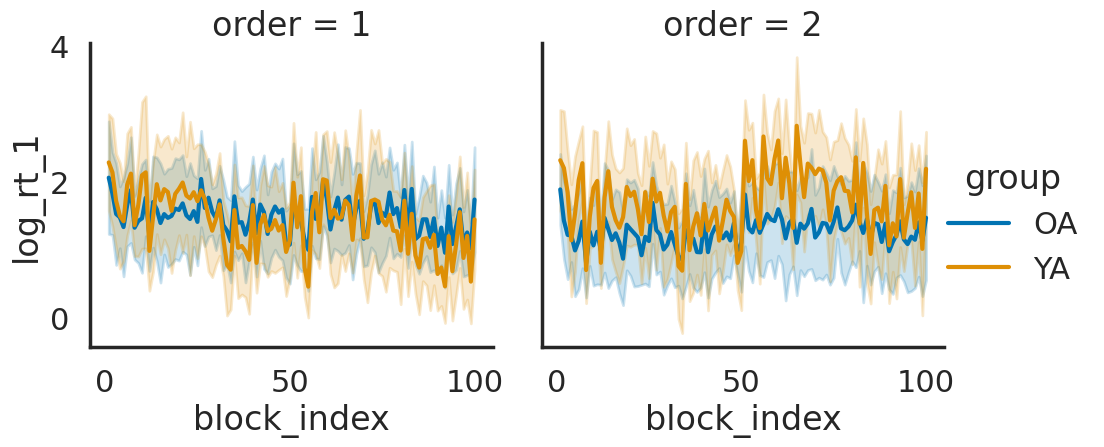

In [4]:
# plot mean of the log(rt_1) with 95% confidence interval or standard deviation
g = sns.FacetGrid(data, col="order", hue='group', height=5)
g = (g.map(sns.lineplot, "block_index", "log_rt_1", ci="sd").add_legend());

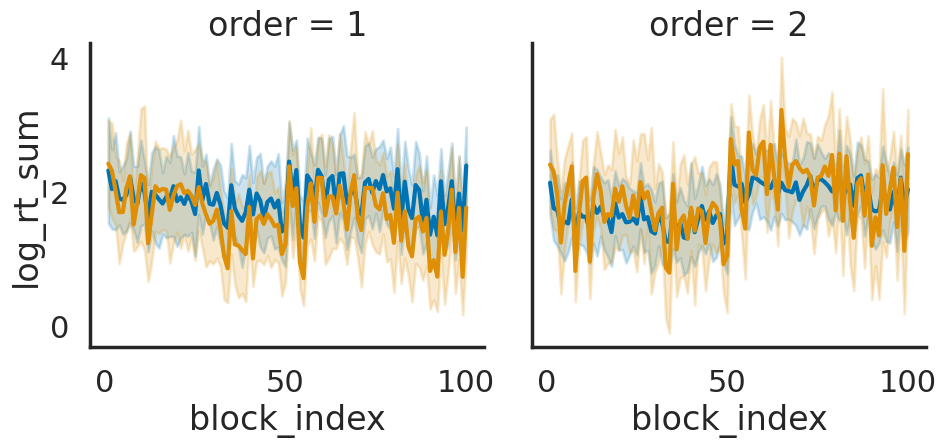

In [5]:
# plot mean of the log(sum rt) 
g = sns.FacetGrid(data, col="order", hue='group', height=5)
g.map(sns.lineplot, "block_index", "log_rt_sum", ci="sd");

In the plots above order = 1 denotes the experimental sequence in which participants start with 2 trial mini-blocks, and after 50 mini-blocks switch to 3 trial mini-blocks. Order = 2 denotes the reversered order in which participants start with 3 trial mini-blocks. The block index denotes the phase dependent index of a mini-block, where in order 1 condition we are counting blocks from 1 to 100, and in order 2 condition from 
50 to 100, and from 1 to 50. Hence, the above plots are aligned with respect to their condition.

To determine quantities which most influence response times we will perform a linear regression with respect to following predictor variables:
- logarithm of mini-block number 
- phase of the experiment 
- number of points at the beggining of the mini-block
- number of failures (surprising jumps) in the mini-block

In [6]:
def get_failures(states, responses):
    transitions = np.array([4., 3., 4., 5., 1., 1.])
    n_subs, n_blocks = states.shape[:2]
    
    failures = np.zeros((n_subs, n_blocks))    
    for i in range(n_subs):
        for j in range(2):
            nans = np.isnan(states[i,:,j+1])
            sts = states[i,~nans,j].astype(int)
            matching_trans = transitions[sts] == states[i,~nans, j+1]
            resp = responses[i,~nans,j].astype(bool)
            failures[i,~nans] += np.logical_xor(matching_trans, resp)
        nans = np.isnan(states[i,:,-1])
        failures[i] -= nans
    
    failures[failures < 0] = 0
    return failures

In [13]:
from pybefit.inference import BayesRegression
from jax import random

T = 100

def sample_posterior(data, states, responses, rng_seed=0):
    rng_key = random.PRNGKey(rng_seed)
    n_subs = len(np.unique(data.subject))
    y1 = data['log_rt_1'].values.reshape(n_subs, T).T
    y2 = data['log_rt_sum'].values.reshape(n_subs, T).T
    X = np.log(np.expand_dims(data['block_number'].values.astype(int).reshape(n_subs, T).T, -1))
    
    # center all non-constant factors per phase
    X -= X.mean(0)
    
    # these are constant per phase
    phases = data.phase.values.astype(int).reshape(n_subs, T).T - 1
    X = np.concatenate([X, np.eye(4)[phases]], -1)

    start_points = data.start_points.values.copy().reshape(n_subs, T).T
    start_points -= start_points.mean(0)
    X = np.concatenate([X, np.expand_dims(start_points, -1)], -1)
    
    rng_key, _rng_key = random.split(rng_key)
    m1 = BayesRegression(_rng_key, np.swapaxes(X, 0, 1))

    states = np.array(states)
    responses = np.array(responses)
    failures = get_failures(states, responses).T
    failures -= failures.mean(0)
    
    X = np.concatenate([X, np.expand_dims(failures, -1)], -1)
    
    rng_key, _rng_key = random.split(rng_key)
    m2 = BayesRegression(_rng_key, np.swapaxes(X, 0, 1))

    samples = []
    waics = []
    for m, y in zip([m1, m2], [y1, y2]):
        samples.append(m.fit(y, num_samples=1000, warmup_steps=5000, summary=False))
        waics.append( m.waic(y) )
        print('model waic', waics[-1])
        
    return samples, [m2, m2], waics

In [14]:
samples_oa, models_oa, waics_oa = sample_posterior(data_old, states_old, responses_old)

sample: 100%|█████████████████████████████████████| 6000/6000 [01:59<00:00, 50.18it/s, 675 steps of size 1.40e-03. acc. prob=0.97]


model waic [1.0320907  0.718707   0.36026627 0.66268384 0.58005655 0.36215726
 0.58022654 0.5993824  0.5556242  0.45742214 0.5688866  0.6535507
 0.97919816 0.77852166 0.41613823 0.21054134 0.4874036  0.4929212
 0.3578734  0.5346346  1.0216388  0.70960295 0.67154944 0.7401564
 0.49994645 0.45921597 0.7185978 ]


sample: 100%|█████████████████████████████████████| 6000/6000 [01:52<00:00, 53.28it/s, 511 steps of size 6.68e-03. acc. prob=0.87]


model waic [0.9008195  0.46997395 0.16133758 0.45548236 0.50298834 0.16951677
 0.51808155 0.50441027 0.6521117  0.43720818 0.3533503  0.49551234
 0.9505361  0.7255327  0.2000622  0.26718533 0.20248865 0.33753395
 0.3104631  0.38231882 0.93326867 0.53256315 0.6514156  0.7380407
 0.3363775  0.2775848  0.5136941 ]


In [15]:
samples_ya, models_ya, waics_ya = sample_posterior(data_young, states_young, responses_young)

sample: 100%|█████████████████████████████████████| 6000/6000 [01:17<00:00, 77.82it/s, 255 steps of size 1.33e-02. acc. prob=0.79]


model waic [0.89902556 0.9438082  0.821263   1.2962545  0.89057016 0.85682446
 0.6743008  0.5391518  1.1189164  1.0505646  1.1341624  0.9979015
 0.9988166  1.1102487  0.86123455 1.093048   0.8336852  0.95125544
 1.20894    0.94476426 0.7804517  0.8932009  1.0522003  0.86796707
 1.099761  ]


sample: 100%|█████████████████████████████████████| 6000/6000 [01:35<00:00, 63.11it/s, 511 steps of size 6.76e-03. acc. prob=0.90]


model waic [0.7780066  0.8293266  0.6252168  1.2600532  0.8096587  0.8652587
 0.52074885 0.4633052  1.0265255  1.0495397  1.202373   0.9686245
 0.9186129  1.0870789  0.8734587  0.8612759  0.68163204 0.84776676
 1.1833394  0.9003826  0.7750663  0.8589065  0.961393   0.75029844
 1.0389698 ]


Bellow we visualise the results of linear regression for young and old adults

In [17]:
### visualise regression results ###
betas = {'OA': {'subject': [], 'group': []}, 'YA':{'subject': [], 'group': []} }
for smpl1, smpl2 in zip(samples_oa, samples_ya):
    betas['OA']['subject'].append(np.array(smpl1['beta']))
    betas['YA']['subject'].append(np.array(smpl2['beta']))
    
    betas['OA']['group'].append( np.array(smpl1['group_beta']) )
    betas['YA']['group'].append( np.array(smpl2['group_beta']) )

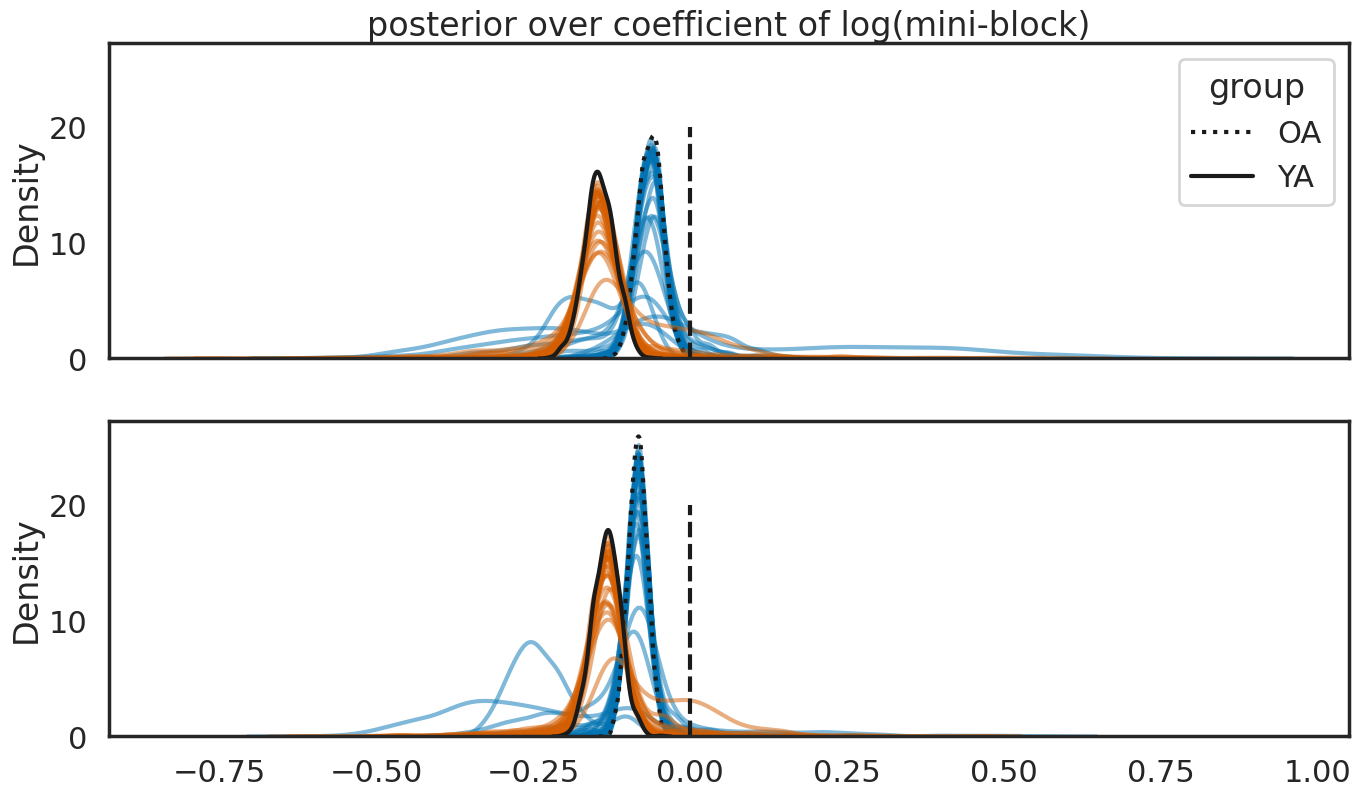

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(16, 9), sharex=True, sharey=True)

color = {'OA': 'b', 'YA': 'r'}
linestyle = {'OA': ':', 'YA': '-'}
for group in betas:
    n_sub = betas[group]['subject'][0].shape[-2]
    for i in range(n_sub):
        sns.kdeplot(betas[group]['subject'][0][:, i, 0], color=color[group], alpha=.5, ax=ax[0], legend=False)  # log_rt_1
        sns.kdeplot(betas[group]['subject'][1][:, i, 0], color=color[group], alpha=.5, ax=ax[1], legend=False)  # log_sum_rt
        
    sns.kdeplot(betas[group]['group'][0][..., 0], color='k', linestyle=linestyle[group], lw=3, ax=ax[0], label=group)  # log_rt_1
    sns.kdeplot(betas[group]['group'][1][..., 0], color='k', linestyle=linestyle[group], lw=3, ax=ax[1], label=group)  # log_sum_rt

ax[0].legend(title='group');
ax[0].vlines(0, 0, 20, 'k', linestyle='--');
ax[1].vlines(0, 0, 20, 'k', linestyle='--');
ax[0].set_title('posterior over coefficient of log(mini-block)');

The black (solid and dotted lines) denote group posterior of teh corresponding coefficient, and individual colored lines represent subject specific posterior estimate of the regression coefficient. Note that yound adults increase their response times with faster rate during the experiment than old adults.

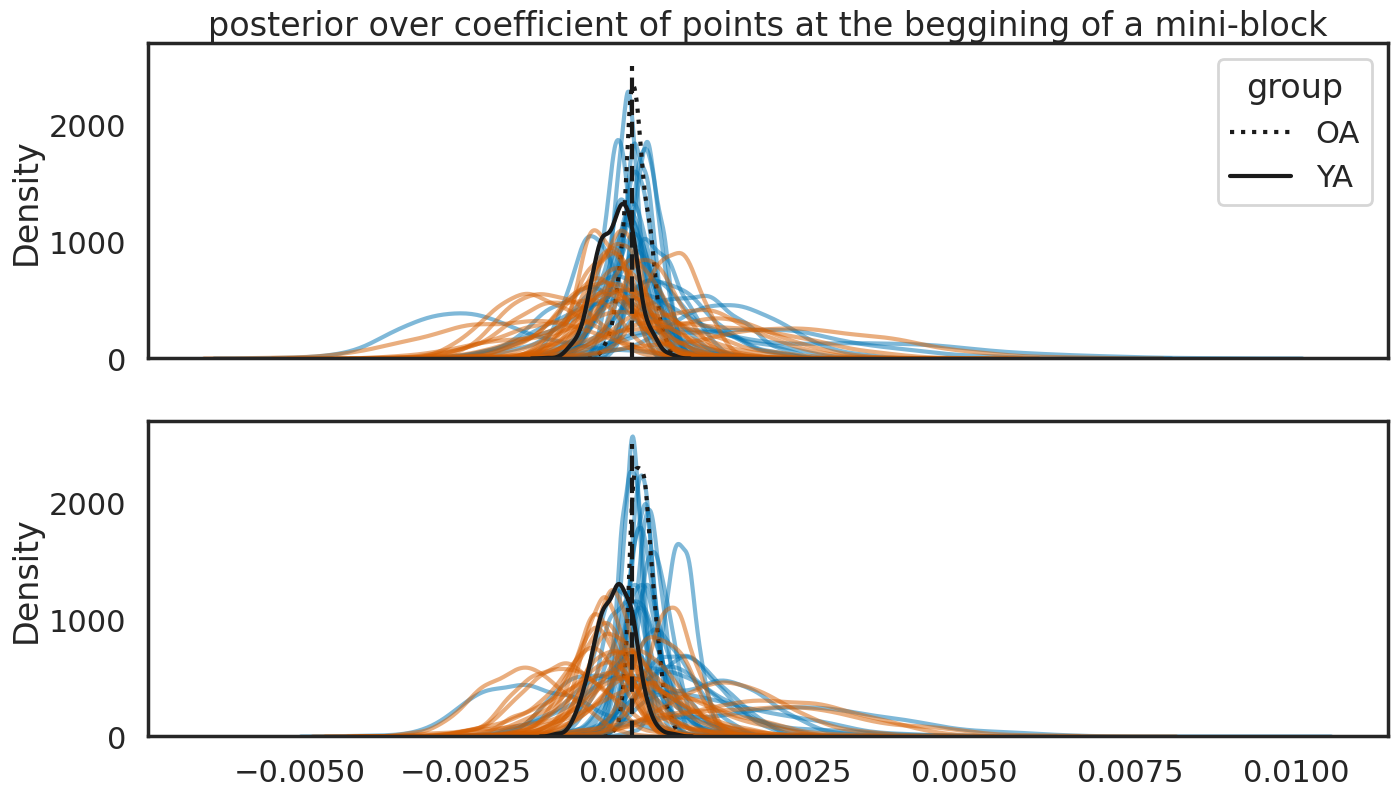

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(16, 9), sharex=True, sharey=True)

for group in betas:
    n_sub = betas[group]['subject'][0].shape[-2]
    for i in range(n_sub):
        sns.kdeplot(betas[group]['subject'][0][:, i, -1], color=color[group], alpha=.5, ax=ax[0], legend=False)  # log_rt_1
        sns.kdeplot(betas[group]['subject'][1][:, i, -2], color=color[group], alpha=.5, ax=ax[1], legend=False)  # log_sum_rt
        
    sns.kdeplot(betas[group]['group'][0][..., -1], color='k', linestyle=linestyle[group], lw=3, ax=ax[0], label=group)  # log_rt_1
    sns.kdeplot(betas[group]['group'][1][..., -2], color='k', linestyle=linestyle[group], lw=3, ax=ax[1], label=group)  # log_sum_rt

ax[0].legend(title='group');
ax[0].vlines(0, 0, 2500, 'k', linestyle='--');
ax[1].vlines(0, 0, 2500, 'k', linestyle='--');
ax[0].set_title('posterior over coefficient of points at the beggining of a mini-block');

As the group posterior estimates contain zero one could conclude that number of points have little influnce on response times in both groups.

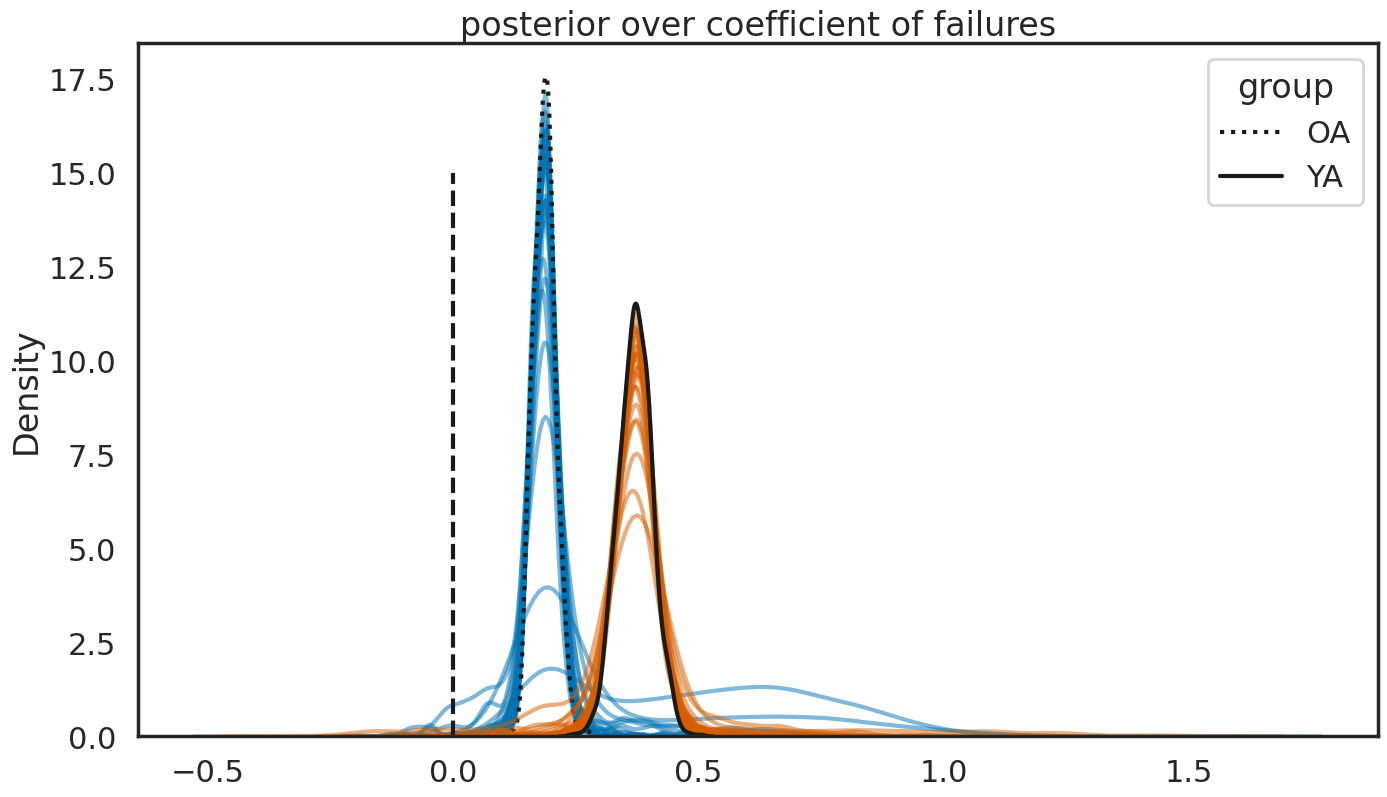

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

for group in betas:
    n_sub = betas[group]['subject'][0].shape[-2]
    for i in range(n_sub):
        sns.kdeplot(betas[group]['subject'][1][:, i, -1], color=color[group], alpha=.5, ax=ax, legend=False)  # log_sum_rt

    sns.kdeplot(betas[group]['group'][1][..., -1], color='k', linestyle=linestyle[group], lw=3, ax=ax, label=group)  # log_sum_rt


plt.legend(title='group');
plt.vlines(0, 0, 15, 'k', linestyle='--');
plt.title('posterior over coefficient of failures');

Interestingly, the number of failures (missed target transition after a 'jump' action) in a mini-block positively impacts response time, where old adults are less affected with missed transition than young adults.

In [46]:
def compare_phase_coefficients(mu_w, sigma_w):
    fig, ax = plt.subplots(2, 2, figsize = (10, 5), sharey = True, sharex = True)

    ax[0,0].errorbar(mu_w[:, 0], mu_w[:, 1], 
                     xerr=sigma_w[:, 0], 
                     yerr=sigma_w[:, 1], 
                     fmt='o',
                     elinewidth = 1,
                     alpha = .8);
    ax[0,1].errorbar(mu_w[:, 3], mu_w[:, 1], 
                     xerr=sigma_w[:, 3], 
                     yerr=sigma_w[:, 1], 
                     fmt='o',
                     elinewidth = 1,
                     alpha = .8);

    ax[1,0].errorbar(mu_w[:, 0], mu_w[:, 2], 
                     xerr=sigma_w[:, 0], 
                     yerr=sigma_w[:, 2], 
                     fmt='o',
                     elinewidth = 1,
                     alpha = .8);

    ax[1,1].errorbar(mu_w[:, 3], mu_w[:, 2], 
                     xerr=sigma_w[:, 3],
                     yerr=sigma_w[:, 2],
                     fmt='o',
                     elinewidth = 1,
                     alpha = .8);

    ax[0,0].set_ylabel(r'$\ln(rt(II))$')
    ax[1,0].set_xlabel(r'$\ln(rt(I))$')
    ax[1,0].set_ylabel(r'$\ln(rt(III))$')
    ax[1,1].set_xlabel(r'$\ln(rt(IV))$')

    x = np.arange(mu_w.min(), mu_w.max(), .1)
    ax[0,0].plot(x, x, 'k--', lw = 2)
    ax[0,1].plot(x, x, 'k--', lw = 2)
    ax[1,0].plot(x, x, 'k--', lw = 2)
    ax[1,1].plot(x, x, 'k--', lw = 2)

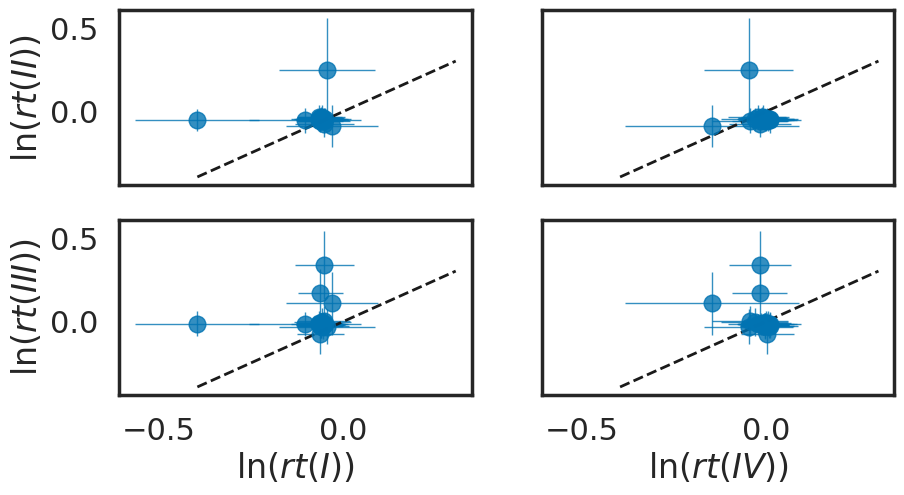

In [47]:
mu_w = betas['OA']['subject'][0][..., 1:5].mean(0) #  log_rt_1
sigma_w = betas['OA']['subject'][0][..., 1:5].std(0)

compare_phase_coefficients(mu_w, sigma_w)

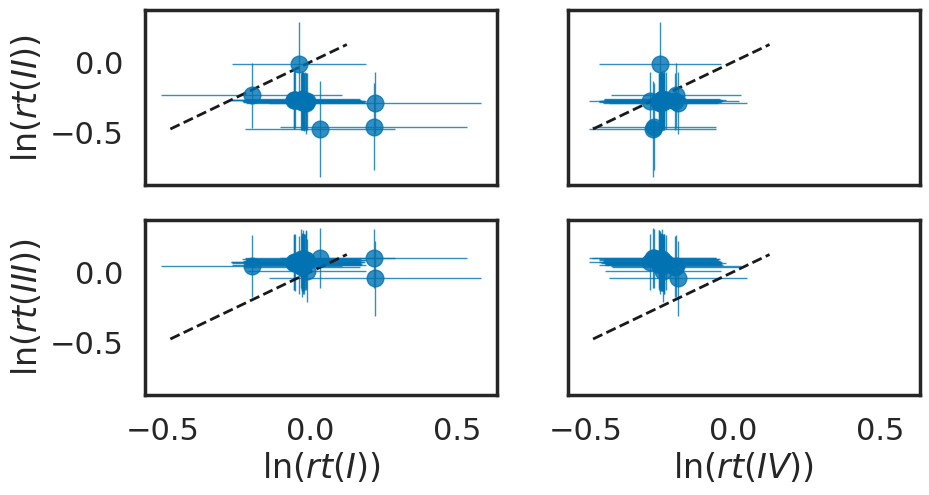

In [48]:
mu_w = betas['YA']['subject'][0][..., 1:5].mean(0)
sigma_w = betas['YA']['subject'][0][..., 1:5].std(0)

compare_phase_coefficients(mu_w, sigma_w)

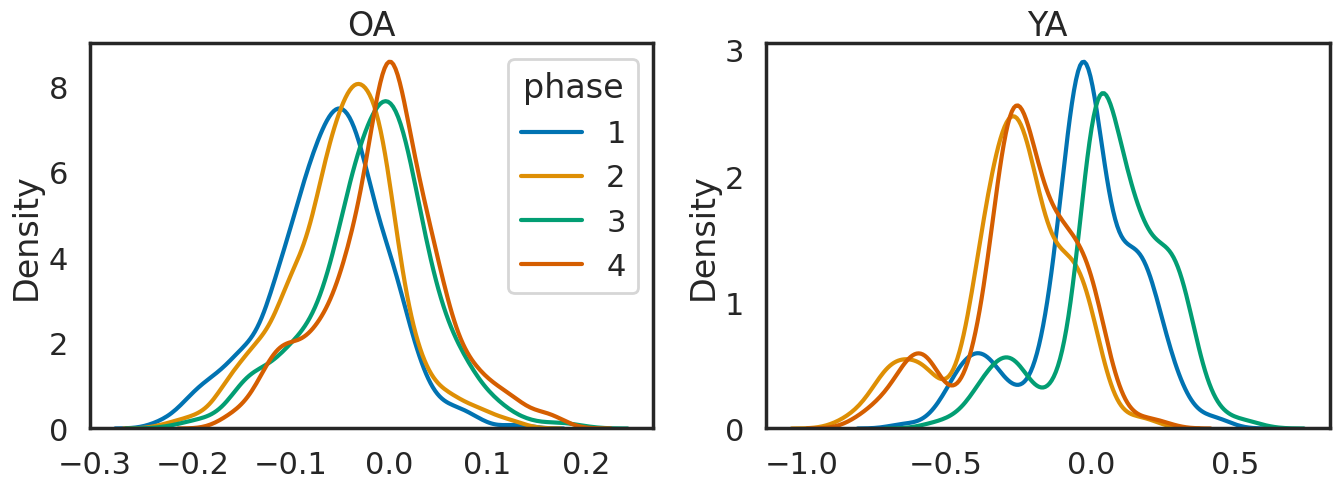

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

#  plot group coefficients for different phases when y = log_rt_1
for i, smpl in enumerate([betas['OA']['group'][0], betas['YA']['group'][0]]):
    for j in range(1, 5):
        sns.kdeplot(smpl[..., j].flatten(), label=j, ax=axes[i])
    
axes[0].legend(title='phase');
axes[0].set_title('OA');
axes[1].set_title('YA');

## Simulated behaviour
In what follows we will compare subjects preformance with the performance of simulated agents

In [60]:
import torch

from pybefit.tasks import SpaceAdventure
from pybefit.agents import VISAT
from simulate import Simulator

exp = io.loadmat('experimental_variables.mat')
starts = exp['startsExp'][:, 0] - 1
planets = exp['planetsExp'] - 1
vect = np.eye(5)[planets]

# setup parameters for the task environment
runs = 50
blocks = 100
na = 2
ns = 6
no = 5

ol1 = torch.from_numpy(vect)
ol2 = torch.from_numpy(np.vstack([vect[50:], vect[:50]]))

starts1 = torch.from_numpy(starts)
starts2 = torch.from_numpy(np.hstack([starts[50:], starts[:50]]))
    
noise = np.tile(np.array([0, 1, 0, 1]), (25,1)).T.flatten()
trials1 = np.tile(np.array([2, 2, 3, 3]), (25,1)).T.flatten()
trials2 = np.tile(np.array([3, 3, 2, 2]), (25,1)).T.flatten()

costs = torch.FloatTensor([-2, -5])  # action costs
fuel = torch.arange(-20., 30., 10.)  # fuel reward of each planet type

confs = torch.stack([ol1, ol2])
confs = confs.view(2, 1, blocks, ns, no).repeat(1, runs//2, 1, 1, 1)\
        .reshape(-1, blocks, ns, no).float()

starts = torch.stack([starts1, starts2])
starts = starts.view(2, 1, blocks).repeat(1, runs//2, 1)\
        .reshape(-1, blocks)
        
conditions = torch.zeros(2, runs, blocks, dtype=torch.long)
conditions[0] = torch.tensor(noise, dtype=torch.long)[None,:]
conditions[1, :runs//2] = torch.tensor(trials1, dtype=torch.long)
conditions[1, runs//2:] = torch.tensor(trials2, dtype=torch.long)

In [61]:
# iterate over different planning depths
agents = []
simulations = []
performance = []
for depth in range(3):
    
    # define space adventure task with aquired configurations
    # set number of trials to the max number of actions
    space_advent = SpaceAdventure(conditions,
                                  outcome_likelihoods=confs,
                                  init_states=starts,
                                  runs=runs,
                                  mini_blocks=blocks,
                                  trials=3)
    
    # define the optimal agent, each with a different maximal planning depth
    agent = VISAT(
        confs,
        runs=runs,
        mini_blocks=blocks,
        trials=3,
        planning_depth=depth+1
    )
    
    agent.set_parameters()
    
    # simulate experiment
    sim = Simulator(space_advent, 
                    agent, 
                    runs=runs, 
                    mini_blocks=blocks,
                    trials=3)
    sim.simulate_experiment()
    
    simulations.append(sim)
    agents.append(agent)
    
    responses = sim.responses.clone()
    responses[torch.isnan(responses)] = 0
    responses = responses.long()
    
    outcomes = sim.outcomes
    
    points = costs[responses] + fuel[outcomes]
    points[outcomes<0] = 0
    performance.append(points.sum(-1))

In [63]:
sim_data = pd.DataFrame()
rel_score = np.zeros((3, 4))

scores = []
for depth in range(3):
    start_points = 1000
    end_points = start_points + performance[depth].numpy().cumsum(-1)
    points = np.hstack([start_points*np.ones((runs, 1)), end_points])
    df = pd.DataFrame(points.T, columns=range(runs))
    df['mini-block'] = np.arange(blocks + 1)
    df = pd.melt(df, id_vars='mini-block', value_vars=range(runs), value_name='points')
    df['order'] = 1
    df.loc[df.variable >= runs//2, 'order'] = 2
    df['depth'] = depth + 1
    sim_data = pd.concat([sim_data, df], ignore_index=True)
    
    phase_values = np.concatenate([start_points*np.ones((runs, 1)), end_points.reshape(-1, 4, 25)[..., -1]], -1)
    diffs = np.diff(phase_values, axis=-1)
                    
    diffs[runs//2:, :] = np.concatenate([diffs[runs//2:, 2:], diffs[runs//2:, :2]], -1)
    scores.append(diffs/25)
    
    rel_score[depth] = diffs.mean(0)/25

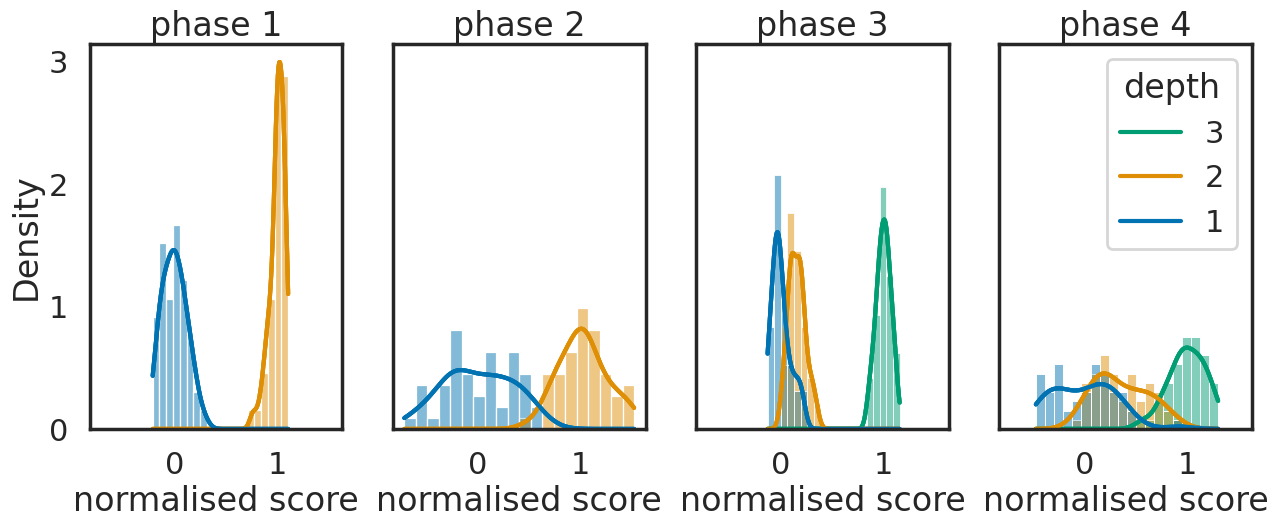

In [69]:
import seaborn as sns
norm_score = np.zeros((3, runs, 4))
for depth in range(3):
    norm_score[depth] = (scores[depth] - rel_score[0])/(rel_score[-1] - rel_score[0])

fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=True, sharey=True)

for i in range(4):
    axes[i].set_title('phase {}'.format(i + 1))
    axes[i].set_xlabel('normalised score')
    for d in range(3):
        if i < 2:
            sns.histplot(norm_score[:2, :, i].T, ax=axes[i], kde=True, bins=20, alpha=.2, stat='density', legend=False)
        else:
            sns.histplot(norm_score[..., i].T, ax=axes[i], kde=True, bins=20, alpha=.2, stat='density', legend=False)
        
axes[-1].legend([3, 2, 1], title='depth');
# fig.savefig('simulates_normalised_scores.pdf', dpi=300)

In [70]:
from scipy.stats import mannwhitneyu, wilcoxon

print(mannwhitneyu(norm_score[-2, :, 0], norm_score[-2, :, 1]))
print(mannwhitneyu(norm_score[-2, :, 0], norm_score[-3, :, 1]))

print(mannwhitneyu(norm_score[-1, :, 2], norm_score[-1, :, 3]))
print(mannwhitneyu(norm_score[-1, :, 2], norm_score[-2, :, 3]))
print(mannwhitneyu(norm_score[-1, :, 2], norm_score[-3, :, 3]))

print(mannwhitneyu(norm_score[-2, :, 0], norm_score[-1, :, 2]))
print(mannwhitneyu(norm_score[-2, :, 1], norm_score[-1, :, 3]))
print(mannwhitneyu(norm_score[-3, :, 1], norm_score[-2, :, 3]))
print(mannwhitneyu(norm_score[-3, :, 1], norm_score[-3, :, 3]))

MannwhitneyuResult(statistic=1191.0, pvalue=0.6866175874811777)
MannwhitneyuResult(statistic=2500.0, pvalue=6.881922449265222e-18)
MannwhitneyuResult(statistic=1213.0, pvalue=0.8013162020551761)
MannwhitneyuResult(statistic=2495.0, pvalue=9.484990934800349e-18)
MannwhitneyuResult(statistic=2491.0, pvalue=1.2060940512538462e-17)
MannwhitneyuResult(statistic=1337.0, pvalue=0.5508126917378806)
MannwhitneyuResult(statistic=1306.0, pvalue=0.7019839324369456)
MannwhitneyuResult(statistic=541.0, pvalue=1.0368855539860204e-06)
MannwhitneyuResult(statistic=1278.0, pvalue=0.8496328748635587)


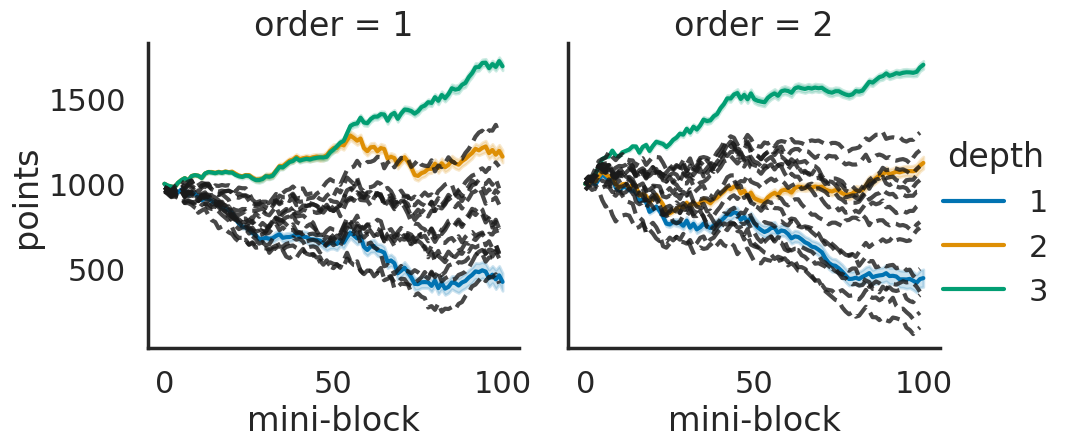

In [71]:
g = sns.FacetGrid(sim_data, col="order", hue='depth', height=5)
g.map(sns.lineplot, "mini-block", "points").add_legend();
mini_blocks = np.arange(1, 101)

for order in range(2):
    for subject in np.unique(data_old.subject.values):
        df = data_old.loc[data_old.order == order+1]
        points = df.loc[df.subject == subject]['end_points'].values
        if len(points) == blocks:
            g.axes[0, order].plot(mini_blocks - 1, points, 'k--', alpha=.8)

In the above plot we are comparing point counts of individual subjects (dashed black lines) with the mean performance of agents with fixed planning depth. Visual inspection sudjest that in the first group of participants (order = 1) one of the participants eventually behaved as agent of planning depth 3, while the other two are mostly behaving as planning depth 1 agents. In the second group (order = 2) we have one participant which was performing in the range between planning depth 2 and 3 agents and another with low planning depth of 1. Overal, this results suggest that old adults are able to performe the task to certain degree but that we should expect large variability in performance (I would expect in the control group performance variability to be much smaller).

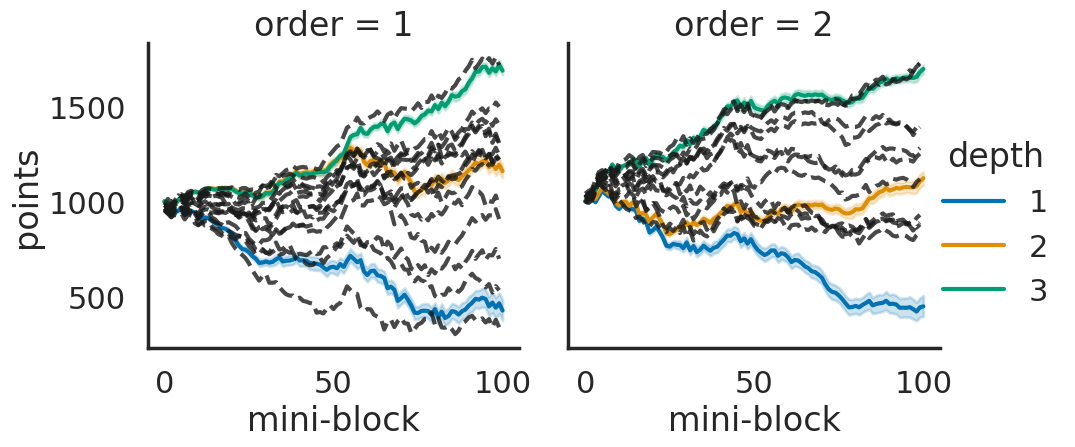

In [72]:
g = sns.FacetGrid(sim_data, col="order", hue='depth', height=5)
g.map(sns.lineplot, "mini-block", "points").add_legend();
mini_blocks = np.arange(1, 101)

for order in range(2):
    for subject in np.unique(data_young.subject.values):
        df = data_young.loc[data_young.order == order+1]
        points = df.loc[df.subject == subject]['end_points'].values
        if len(points) == blocks:
            g.axes[0, order].plot(mini_blocks - 1, points, 'k--', alpha=.8)

Compared to old adults, in the young adults data set we find larger percentage of participants that used the maximal planning depth throughout the experiment.

MannwhitneyuResult(statistic=342.0, pvalue=0.3517502321879521)
MannwhitneyuResult(statistic=290.0, pvalue=0.1002334187998698)
MannwhitneyuResult(statistic=297.0, pvalue=0.12320803330116897)
MannwhitneyuResult(statistic=353.0, pvalue=0.4245357069698535)


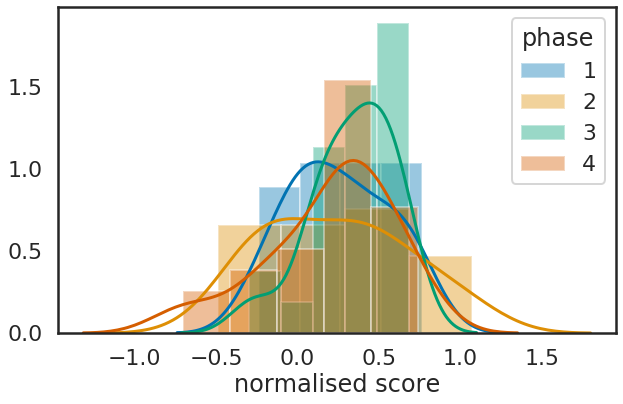

In [30]:
# load planning depth statistics for OA group
pd_stats_oa = np.load('oa_plandepth_stats_B03.npz', allow_pickle=True)
pd_prob_oa = pd_stats_oa['arr_1'][0]  # planning depth probability for the first choice

ep_count_oa = pd_stats_oa['arr_2'][0]  # exc. prob. count for the first choice
ep_prob_oa = ep_count_oa/ep_count_oa.sum(0)
ep_oa = ep_prob_oa.reshape(3, 4, 25, -1).mean(-2)
#######################################################################3

n_subs = pd_prob_oa.shape[1]

score = data_old['gain'].values.reshape(n_subs, 4, -1).sum(-1)/25
order = data_old.order.values.reshape(n_subs, -1)[:, 0]
rev = order == 2

mpd_all_oa = pd_prob_oa.dot(np.arange(1, 4)).reshape(4, 25, -1)
mpd_oa = mpd_all_oa.mean(-2).T
vpd_oa = mpd_all_oa.std(-2).T

mpd_all_oa[..., rev] = np.concatenate([mpd_all_oa[2:, :, rev], mpd_all_oa[:2, :, rev]], 0)
mpd_oa[rev] = np.concatenate([mpd_oa[rev, 2:], mpd_oa[rev, :2]], -1)
vpd_oa[rev] = np.concatenate([vpd_oa[rev, 2:], vpd_oa[rev, :2]], -1)
ep_oa[..., rev] = np.concatenate([ep_oa[:, 2:, rev], ep_oa[:, :2, rev]], -2)

# create data frame with ep and entorpy estimates
data_oa = pd.DataFrame(data=ep_oa[[-2, -2, -1, -1], [0, 1, 2, 3]].T, columns=[1, 2, 3, 4])
data_oa['order'] = order
data_oa = data_oa.melt(id_vars='order', var_name='phase', value_name='EP(depth=max)')
data_oa['group'] = 'OA'

df = pd.DataFrame(data=vpd_oa, columns=[1, 2, 3, 4])
data_oa['std'] = df.melt(var_name='phase', value_name='entropy')['entropy']

score[rev] = np.concatenate([score[rev, 2:], score[rev, :2]], -1)
norm_score1 = (score - rel_score[0])/(rel_score[-1] - rel_score[0])

fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)

axes.set_xlabel('normalised score')
for i in range(4):
    sns.distplot(norm_score1[:, i], ax=axes)
    
axes.legend([1, 2, 3, 4], title='phase')

from scipy.stats import mannwhitneyu, wilcoxon

print(mannwhitneyu(norm_score1[:, 0], norm_score1[:, 1]))
print(mannwhitneyu(norm_score1[:, 2], norm_score1[:, 3]))
print(mannwhitneyu(norm_score1[:, 0], norm_score1[:, 2]))
print(mannwhitneyu(norm_score1[:, 1], norm_score1[:, 3]))

MannwhitneyuResult(statistic=263.0, pvalue=0.17086248206683657)
MannwhitneyuResult(statistic=217.0, pvalue=0.03263828642241747)
MannwhitneyuResult(statistic=266.0, pvalue=0.18604842492052281)
MannwhitneyuResult(statistic=232.0, pvalue=0.060294924946948956)


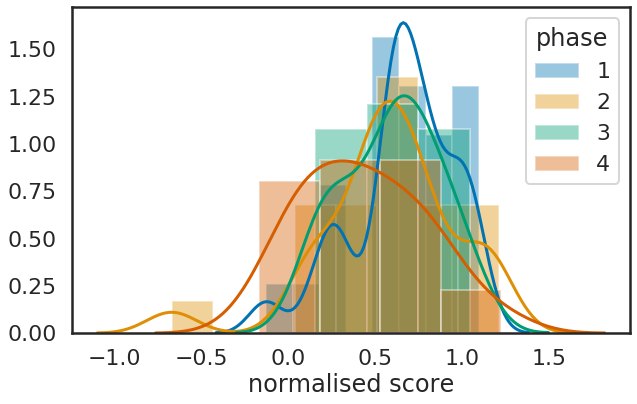

In [31]:
# load planning depth statistics for YA group
pd_stats_ya = np.load('ya_plandepth_stats_B03.npz', allow_pickle=True)
pd_prob_ya = pd_stats_ya['arr_1'][0]  # planning depth probability for the first choice

ep_count_ya = pd_stats_ya['arr_2'][0]  # exc. prob. count for the first choice
ep_prob_ya = ep_count_ya/ep_count_ya.sum(0)
ep_ya = ep_prob_ya.reshape(3, 4, 25, -1).mean(-2)
####################################################################################

n_subs = pd_prob_ya.shape[1]

mpd_all_ya = pd_prob_ya.dot(np.arange(1, 4)).reshape(4, 25, -1)
mpd_ya = mpd_all_ya.mean(-2).T
vpd_ya = mpd_all_ya.std(-2).T

order = data_young.order.values.reshape(n_subs, -1)[:, 0]
rev = order == 2

mpd_all_ya[..., rev] = np.concatenate([mpd_all_ya[2:, :, rev], mpd_all_ya[:2, :, rev]], 0)
mpd_ya[rev] = np.concatenate([mpd_ya[rev, 2:], mpd_ya[rev, :2]], -1)
vpd_ya[rev] = np.concatenate([vpd_ya[rev, 2:], vpd_ya[rev, :2]], -1)
ep_ya[..., rev] = np.concatenate([ep_ya[:, 2:, rev], ep_ya[:, :2, rev]], -2)

data_ya = pd.DataFrame(data=ep_ya[[-2, -2, -1, -1], [0, 1, 2, 3]].T, columns=[1, 2, 3, 4])
data_ya['order'] = order
data_ya = data_ya.melt(id_vars='order', var_name='phase', value_name='EP(depth=max)')
data_ya['group'] = 'YA'

df = pd.DataFrame(data=vpd_ya, columns=[1, 2, 3, 4])
data_ya['std'] = df.melt(var_name='phase', value_name='entropy')['entropy']

data = pd.concat([data_oa, data_ya], ignore_index=True)

score = data_young['gain'].values.reshape(n_subs, 4, -1).sum(-1)/25
score[rev] = np.concatenate([score[rev, 2:], score[rev, :2]], -1)
norm_score2 = (score - rel_score[0])/(rel_score[-1] - rel_score[0])

fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
axes.set_xlabel('normalised score')
for i in range(4):
    sns.distplot(norm_score2[:, i], ax=axes)
    
axes.legend([1, 2, 3, 4], title='phase')

from scipy.stats import mannwhitneyu, wilcoxon

print(mannwhitneyu(norm_score2[:, 0], norm_score2[:, 1]))
print(mannwhitneyu(norm_score2[:, 2], norm_score2[:, 3]))
print(mannwhitneyu(norm_score2[:, 0], norm_score2[:, 2]))
print(mannwhitneyu(norm_score2[:, 1], norm_score2[:, 3]))

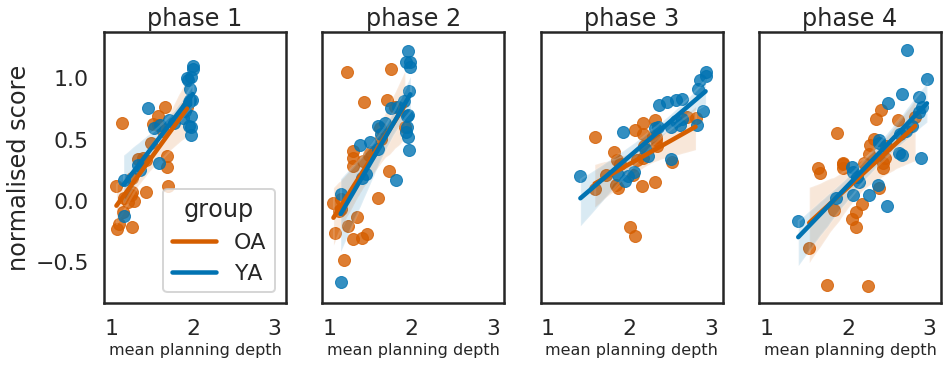

In [32]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True, sharex=True)

mpd = [mpd_oa, mpd_ya]
ns = [norm_score1, norm_score2]
color = ['r', 'b'] 
for j in range(2):
    for i in range(4):
        sns.regplot(mpd[j][:, i], ns[j][:, i], ax=axes[i], color=color[j])
        axes[i].set_title('phase {}'.format(i+1));
        axes[i].set_xlabel('mean planning depth', fontsize=16);
    
axes[0].set_ylabel('normalised score');
axes[0].legend(['OA', 'YA'], title='group')

fig.savefig('score_vs_depth_B03.pdf', dpi=300)    

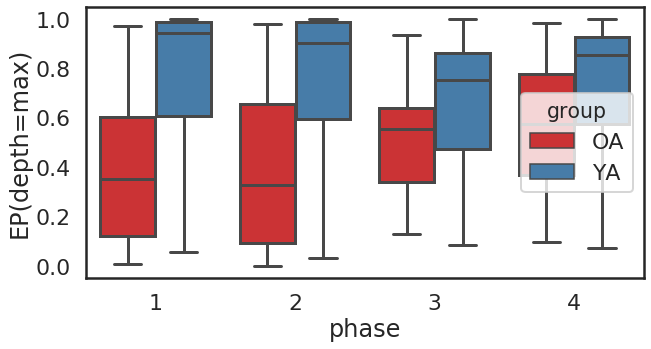

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot('phase', 'EP(depth=max)', data=data, hue='group', ax=ax, palette='Set1')

# fig.savefig('ep_dist_B03.pdf', dpi=300)

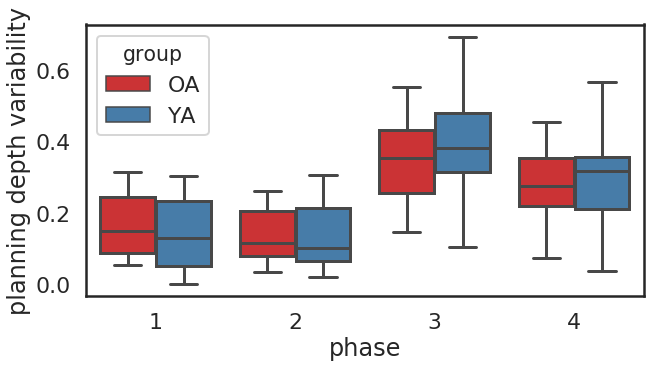

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot('phase', 'std', data=data, hue='group', ax=ax, palette='Set1')
ax.set_ylabel('planning depth variability')

# fig.savefig('variability_dist_B03.pdf', dpi=300)

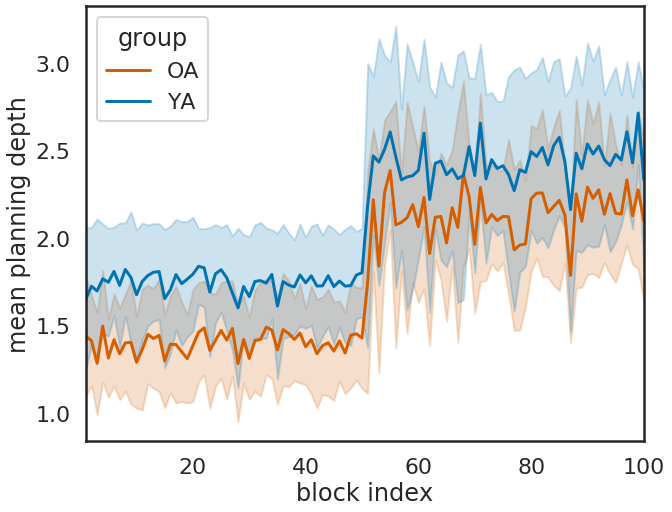

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

df1 = pd.DataFrame(mpd_all_oa.reshape(blocks, -1))
df1['block_index'] = np.arange(1, blocks+1)
df1 = df1.melt(id_vars=['block_index'], var_name='subject')

df2 = pd.DataFrame(mpd_all_ya.reshape(blocks, -1))
df2['block_index'] = np.arange(1, blocks+1)
df2 = df2.melt(id_vars=['block_index'], var_name='subject')

sns.lineplot(x='block_index', y='value', data=df1, color='r', ci='sd', label='OA');
sns.lineplot(x='block_index', y='value', data=df2, color='b', ci='sd', label='YA');

ax.set_ylabel('mean planning depth');
ax.set_xlabel('block index');
ax.legend(title='group', loc=2);
ax.set_xlim([1, 100]);

fig.savefig('build3_b03.png', dpi=600)
fig.savefig('build3_b03.svg', dpi=300)


In [113]:
n_sub_oa = mpd_oa.shape[0]
n_sub_ya = mpd_ya.shape[0]

ids = [data_old['ID'].values.reshape(n_sub_oa, -1)[:, 0],
       data_young['ID'].values.reshape(n_sub_ya, -1)[:, 0]]
gl = ['OA', 'YA']
mpd = [mpd_oa, mpd_ya]
ns = [norm_score1, norm_score2]
vpd = [vpd_oa, vpd_ya]
ep = [ep_oa[[-2, -2, -1, -1], [0, 1, 2, 3]], ep_ya[[-2, -2, -1, -1], [0, 1, 2, 3]]]

results = pd.DataFrame()
for g in range(2):
    for phase in range(4):
        df = pd.DataFrame({'PD': mpd[g][:, phase], 
                           'NS': ns[g][:, phase],
                           'STD': vpd[g][:, phase],
                           'EP(depth=max)': ep[g][phase],
                           'subject': np.arange(1, ns[g].shape[0] +1),
                           'ID': ids[g],
                           'phase': phase + 1,
                           'group': gl[g]})
        
        results = results.append(df, ignore_index=True)
        
results.to_csv('NS_PD_Entropy_B03.csv')

MannwhitneyuResult(statistic=2576.0, pvalue=3.752240703815699e-11)

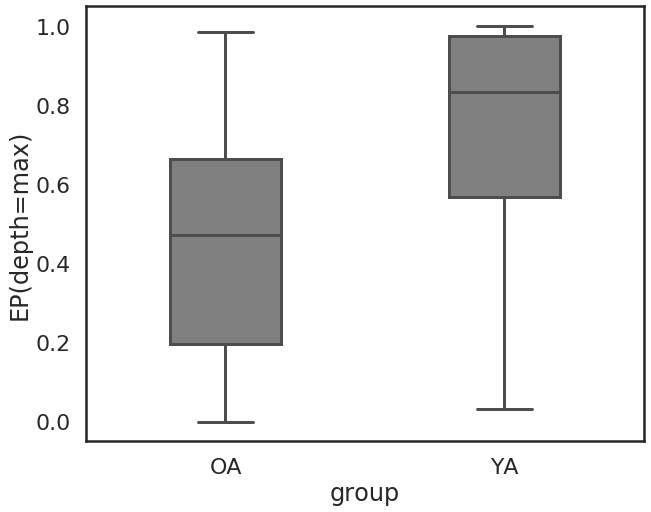

In [87]:
data = data_oa.append(data_ya, ignore_index=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.boxplot('group', 'EP(depth=max)', data=results, ax=ax, color='gray', width=0.4)

fig.savefig('bild2_B03.eps', dpi=300)
fig.savefig('bild2_B03.png', dpi=600)

mannwhitneyu(results.loc[results.group == 'OA', 'EP(depth=max)'], results.loc[results.group == 'YA', 'EP(depth=max)'])

MannwhitneyuResult(statistic=5315.0, pvalue=0.4227618798022342)

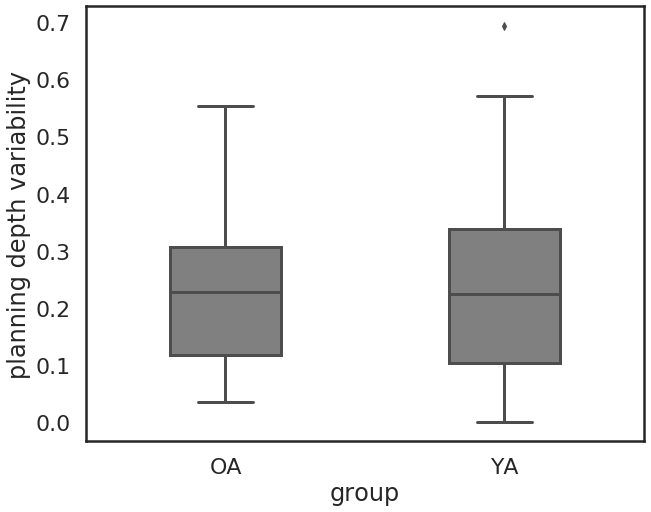

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.boxplot(x='group', y='STD', data=results, color='gray', width=0.4)

ax.set_ylabel('planning depth variability')

fig.savefig('planning_depth_variability_B03.eps', dpi=300)
fig.savefig('planning_depth_variability_B03.png', dpi=600)

mannwhitneyu(results.loc[results.group == 'OA', 'STD'], results.loc[results.group == 'YA', 'STD'])

MannwhitneyuResult(statistic=3430.0, pvalue=2.7980015114332186e-06)

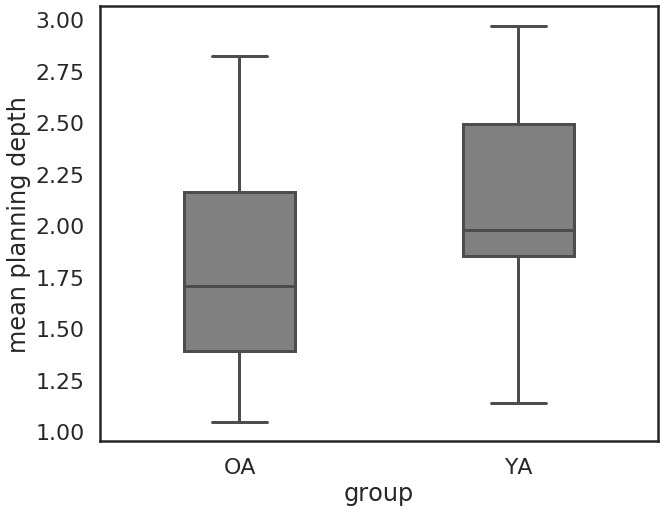

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.boxplot(x='group', y='PD', data=results, color='gray', width=0.4)

ax.set_ylabel('mean planning depth')


fig.savefig('bild1_B03.eps', dpi=300)
fig.savefig('bild1_B03.png', dpi=600)
mannwhitneyu(results.loc[results.group == 'OA', 'PD'], results.loc[results.group == 'YA', 'PD'])